In [1]:
import pandas as pd
import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from BS_generator import *

Generated BS Option Prices Grid (shape): (25, 50)
Epoch 200/2000, Loss: 0.002401
Epoch 400/2000, Loss: 0.001770
Epoch 600/2000, Loss: 0.001573
Epoch 800/2000, Loss: 0.001361
Epoch 1000/2000, Loss: 0.001117
Epoch 1200/2000, Loss: 0.000848
Epoch 1400/2000, Loss: 0.000579
Epoch 1600/2000, Loss: 0.000346
Epoch 1800/2000, Loss: 0.000179
Epoch 2000/2000, Loss: 0.000083


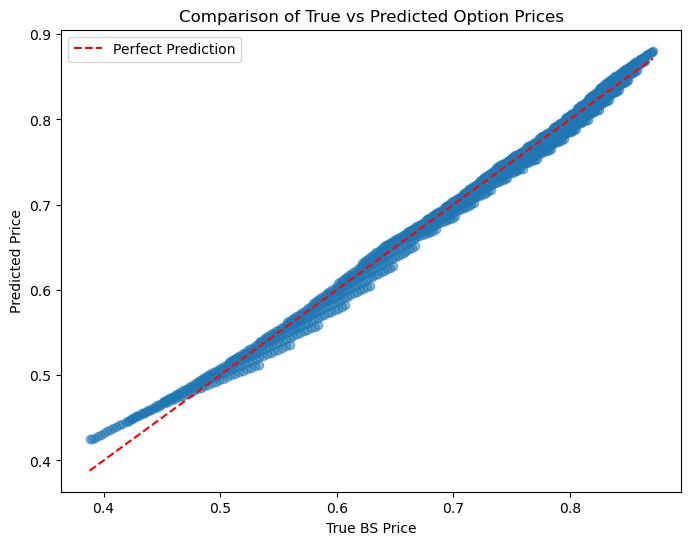

In [2]:

S0 = 1.0
r = 0.025
sigma = 0.2  

maturities = np.arange(16, 65, 2) 
strikes = np.linspace(0.8, 1.2, 50)    


option_prices = generate_option_prices(S0, r, sigma, maturities, strikes, option_type='call')
print("Generated BS Option Prices Grid (shape):", option_prices.shape)


T_grid, K_grid = np.meshgrid(maturities, strikes, indexing='ij') 
X = np.stack([T_grid.ravel(), K_grid.ravel()], axis=1)  
y = option_prices.ravel()

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

class BSPriceNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=1):
        super(BSPriceNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = BSPriceNN()


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 2000


for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.6f}")


model.eval()
with torch.no_grad():
    predicted = model(X_tensor).detach().numpy()


plt.figure(figsize=(8,6))
plt.scatter(y, predicted, alpha=0.5)
plt.xlabel("True BS Price")
plt.ylabel("Predicted Price")
plt.title("Comparison of True vs Predicted Option Prices")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Prediction")
plt.legend()
plt.show()


In [3]:
maturities = np.arange(17, 66, 2) 
strikes = np.linspace(0.8, 1.2, 50)    
option_prices = generate_option_prices(S0, r, sigma, maturities, strikes, option_type='call')

Test Option Prices Grid Shape: (10, 10)


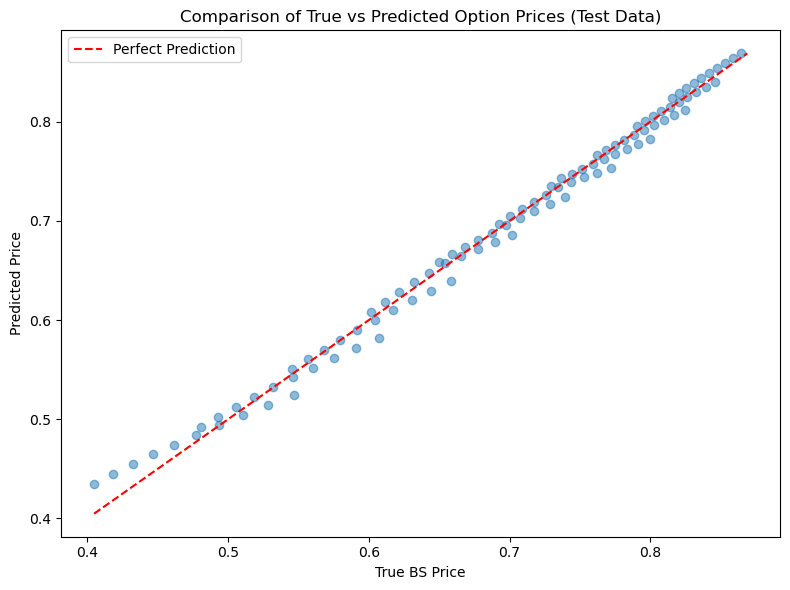

In [ ]:
test_maturities = np.arange(17, 66, 5)     
test_strikes = np.linspace(0.8, 1.2, 10)      


option_prices_true = generate_option_prices(S0, r, sigma, test_maturities, test_strikes, option_type='call')
print("Test Option Prices Grid Shape:", option_prices_true.shape)


T_grid, K_grid = np.meshgrid(test_maturities, test_strikes, indexing='ij')
X_test = np.stack([T_grid.ravel(), K_grid.ravel()], axis=1) 
y_true = option_prices_true.ravel() 

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.detach().cpu().numpy().ravel()


plt.figure(figsize=(8,6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.xlabel("True BS Price")
plt.ylabel("Predicted Price")
plt.title("Comparison of True vs Predicted Option Prices (Test Data)")

min_val = min(y_true.min(), y_pred.min())
max_val = max(y_true.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Perfect Prediction")
plt.legend()
plt.tight_layout()
plt.show()
